In [1]:
%matplotlib inline


Filtering and resampling data
=============================




Some artifacts are restricted to certain frequencies and can therefore
be fixed by filtering. An artifact that typically affects only some
frequencies is due to the power line.

Power-line noise is a noise created by the electrical network.
It is composed of sharp peaks at 50Hz (or 60Hz depending on your
geographical location). Some peaks may also be present at the harmonic
frequencies, i.e. the integer multiples of
the power-line frequency, e.g. 100Hz, 150Hz, ... (or 120Hz, 180Hz, ...).

This tutorial covers some basics of how to filter data in MNE-Python.
For more in-depth information about filter design in general and in
MNE-Python in particular, check out [this link](https://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html)

In [2]:
import mne
from mne.datasets import sample

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

Setup for reading the raw data (save memory by cropping the raw data
before loading it)

In [3]:
tmin, tmax = 0, 20  # use the first 20s of data

raw = mne.io.read_raw_fif(raw_fname)
raw.crop(tmin, tmax).load_data()
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # bads + 2 more

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 12012  =      0.000 ...    20.000 secs...


Pick a subset of channels (here for speed reason)

In [4]:
selection = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads', selection=selection)

Let's first check out all channel types

Effective window size : 3.410 (s)


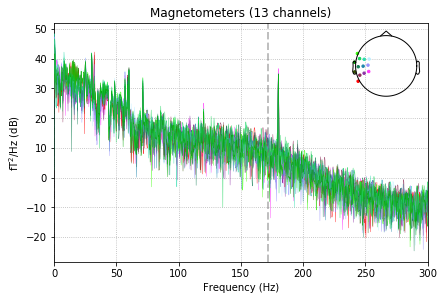

In [5]:
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

Removing power-line noise with notch filtering
----------------------------------------------

Removing power-line noise can be done with a Notch filter, directly on the
Raw object, specifying an array of frequency to be cut off:



Setting up band-stop filter
Filter length of 3965 samples (6.602 sec) selected
Effective window size : 3.410 (s)


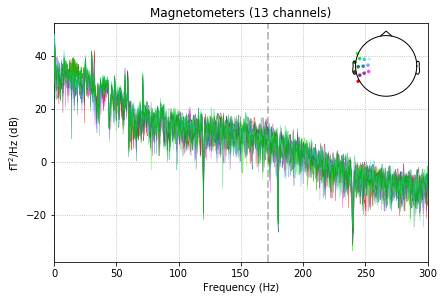

In [6]:
import numpy as np

raw.notch_filter(np.arange(60, 241, 60), picks=picks, filter_length='auto',
                 phase='zero')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

Removing power-line noise with low-pass filtering
-------------------------------------------------

If you're only interested in low frequencies, below the peaks of power-line
noise you can simply low pass filter the data.



Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 159 samples (0.265 sec) selected
Effective window size : 3.410 (s)


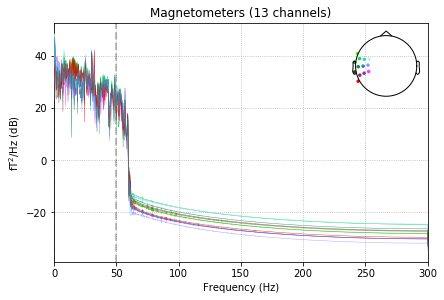

In [7]:
raw.filter(None, 50., fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

High-pass filtering to remove slow drifts
-----------------------------------------

To remove slow drifts, you can high pass.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1983 samples (3.302 sec) selected
Effective window size : 3.410 (s)


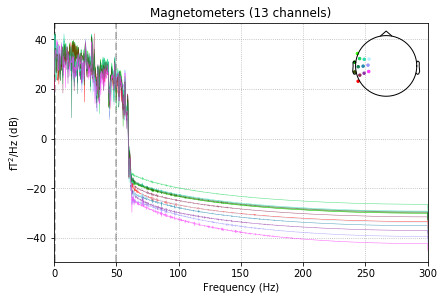

In [8]:
raw.filter(1., None, fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

To do the low-pass and high-pass filtering in one step you can do
a so-called *band-pass* filter by running the following:



In [9]:
raw.filter(1, 50., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 1983 samples (3.302 sec) selected


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 12013 (20.0 sec), ~38.1 MB, data loaded>

Downsampling and decimation
--------------------------- 

When performing experiments where timing is critical, a signal with a high
sampling rate is desired.

However, having a signal with a much higher
sampling rate than necessary needlessly consumes memory and slows down
computations operating on the data. To avoid that, you can downsample
your time series.

Data resampling can be done with *resample* methods.

25 events found
Event IDs: [ 1  2  3  4  5 32]
25 events found
Event IDs: [ 1  2  3  4  5 32]
Effective window size : 10.010 (s)


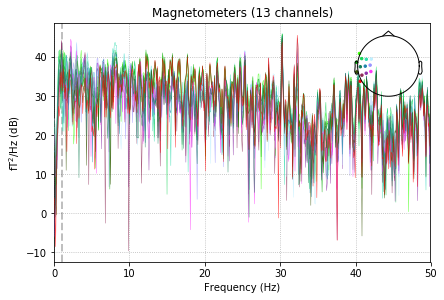

In [10]:
raw.resample(100, npad="auto")  # set sampling frequency to 100Hz
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks);

**Warning**: This will reduce the timing precision of events

To avoid this reduction in precision, the suggested pipeline for
processing final data to be analyzed is:

   1. low-pass the data with `mne.io.Raw.filter`.
   2. Extract epochs with `mne.Epochs`.
   3. Decimate the Epochs object using `mne.Epochs.decimate` or the
      ``decim`` argument to the `mne.Epochs` object.



We also provide the convenience methods `mne.Epochs.resample` and
`mne.Evoked.resample` to downsample or upsample data, but these are
less optimal because they will introduce edge artifacts into every epoch,
whereas filtering the raw data will only introduce edge artifacts only at
the start and end of the recording.